In [1]:
import pycurl
import StringIO
import time
import csv

def oneday(start,symbol):
    st = time.strptime(start, '%Y-%m-%d %H:%M:%S')
    pytime1 = time.mktime(st)*1000
    pytime2 = pytime1+60*60*12*1000
    list1 = getprice(pytime1,symbol)
    list2 = getprice(pytime2,symbol)
    listall = list1+list2
    
    for l in listall:
        st = time.localtime(l[0]/1000)
        l[0] = time.strftime('%Y-%m-%d %H:%M:%S', st)       

    csvfile = open(symbol+start[:10]+'.csv', 'wb')
    writer = csv.writer(csvfile)
    writer.writerow(['MTS', 'OPEN', 'CLOSE', 'HIGH', 'LOW', 'VOLUME'])
    writer.writerows(listall)
    csvfile.close()

def getprice(pytime,symbol):
    url='https://api.bitfinex.com/v2/candles/trade:1m:'+symbol+'/hist?limit=720&start='+str(int(pytime))+'&sort=1'
    c=pycurl.Curl()
    c.setopt(c.URL, url)
    b = StringIO.StringIO()
    c.setopt(c.WRITEFUNCTION, b.write)
    c.perform()
    price=eval(b.getvalue())
    return price

In [2]:
oneday('2018-12-14 00:00:00','tBTCUSD')

In [3]:
oneday('2018-12-15 00:00:00','tBTCUSD')

In [4]:
# Input data files are available in the "../input/" directory.
import pandas as pd
from subprocess import check_output

print check_output(["ls", "."]).decode("utf8")

AR Prediction.ipynb
Bitcoin Price Time Series Prediction Using ARMA & LSTM Model.pdf
GetData_oneyear.ipynb
input
LSTM Prediction.ipynb
README.md
tBTCUSD2017-12-14.csv
tBTCUSD2017-12-15.csv
tBTCUSD2018-12-14.csv
tBTCUSD2018-12-15.csv



In [5]:
oneday = pd.read_csv("tBTCUSD2018-12-14.csv", index_col='MTS')  
oneday.index = pd.to_datetime(oneday.index)   

openprice = oneday['OPEN']  
closeprice = oneday['CLOSE']
highprice = oneday['HIGH']
lowprice = oneday['LOW']

In [6]:
oneday.head()

,OPEN,CLOSE,HIGH,LOW,VOLUME
MTS,,,,,
2018-12-14 00:00:00,3357.700000,3359.5,3360.0,3357.7,15.391929
2018-12-14 00:01:00,3359.600000,3360.0,3360.0,3359.6,3.663016
2018-12-14 00:02:00,3359.934622,3360.0,3360.0,3359.9,10.773534
2018-12-14 00:03:00,3360.000000,3360.9,3360.9,3360.0,11.601627
2018-12-14 00:04:00,3361.000000,3361.0,3361.0,3360.9,5.011997


In [7]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    
    rol_mean = timeSeries.rolling(window=size).mean()
  
    rol_weighted_mean = timeSeries.ewm(span=size).mean()
    
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

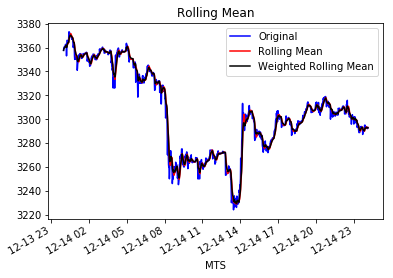

In [8]:
draw_trend(lowprice, 10)

In [9]:
def testStationarity(ts):
    dftest = adfuller(ts)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [10]:
testStationarity(lowprice)

Test Statistic                   -1.887120
p-value                           0.338144
#Lags Used                        1.000000
Number of Observations Used    1438.000000
Critical Value (5%)              -2.863552
Critical Value (1%)              -3.434906
Critical Value (10%)             -2.567841
dtype: float64

In [11]:

def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

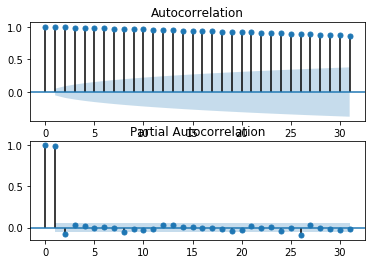

In [12]:
draw_acf_pacf(lowprice)

In [13]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(lowprice, order=(1, 2)) 
result_arma = model.fit( disp=-1, method='css')

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
predict_ts = result_arma.predict()

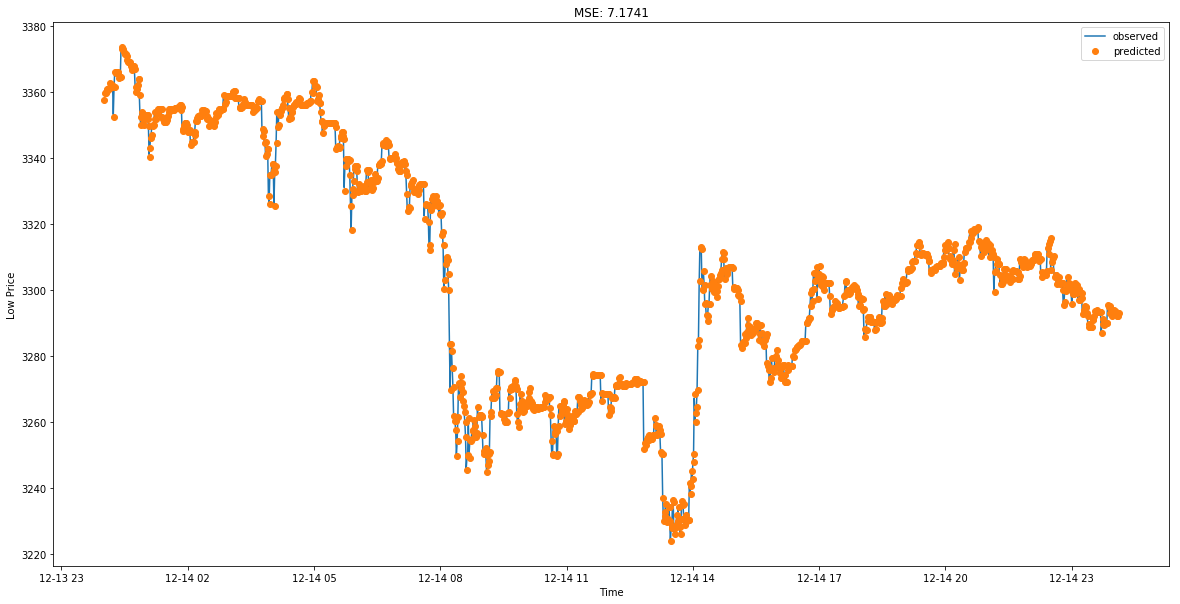

In [15]:
import matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
lowprice = lowprice[predict_ts.index]  
ax.set(title='MSE: %.4f'% (sum((predict_ts-lowprice)**2)/lowprice.size), xlabel='Time', ylabel='Low Price')
ax.plot(lowprice, '-', label='observed')
ax.plot(predict_ts,'o', label='predicted')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.show()

In [31]:
test = pd.read_csv("tBTCUSD2018-12-15.csv", index_col='MTS') 
test.index = pd.to_datetime(test.index)   


test_lowprice = test['LOW']

In [32]:
from sklearn.metrics import mean_squared_error

history = [x for x in lowprice]
predictions = list()

In [33]:
# predict the lower price for next minute
print('Printing Predicted vs Expected Values...')
print('\n')
#for t in range(len(test_lowprice)):
for t in range(120): # next two hours
    model = ARMA(history, order=(1,2))
    model_fit = model.fit(disp=-1,start_ar_lags=13)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test_lowprice[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
    print('predicted=%f, expected=%f' % (yhat, obs))

Printing Predicted vs Expected Values...


predicted=3292.947619, expected=3293.700000
predicted=3293.812714, expected=3292.900000
predicted=3292.875886, expected=3293.100000
predicted=3293.195056, expected=3292.900000
predicted=3292.932764, expected=3292.100000
predicted=3292.106244, expected=3292.100000
predicted=3292.178720, expected=3292.780501
predicted=3292.884494, expected=3292.900000
predicted=3292.947339, expected=3294.900000
predicted=3295.097871, expected=3294.900000
predicted=3294.897689, expected=3294.900000
predicted=3294.958505, expected=3294.334526
predicted=3294.344015, expected=3294.455453
predicted=3294.532196, expected=3296.300000
predicted=3296.478423, expected=3296.700000
predicted=3296.727747, expected=3296.800000
predicted=3296.849723, expected=3297.048798
predicted=3297.110461, expected=3297.100000
predicted=3297.143302, expected=3296.700000
predicted=3296.716869, expected=3297.388082
predicted=3297.494678, expected=3297.400000
predicted=3297.426083, expected=3

In [34]:
error = mean_squared_error(test_lowprice[:120], predictions)

#print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test_lowprice.index[:120])

Printing Mean Squared Error of Predictions...
Test MSE: 4.210244


In [35]:
import matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
ax.set(title='Low Price Prediction', xlabel='Time', ylabel='Low Price')
ax.plot(lowprice, '-', label='observed')
ax.plot(test_lowprice[:120], 'o', label='true label (one-step out-of-sample forecast)')
ax.plot(predictions_series, 'g', label='predicted label (one-step out-of-sample forecast)')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  

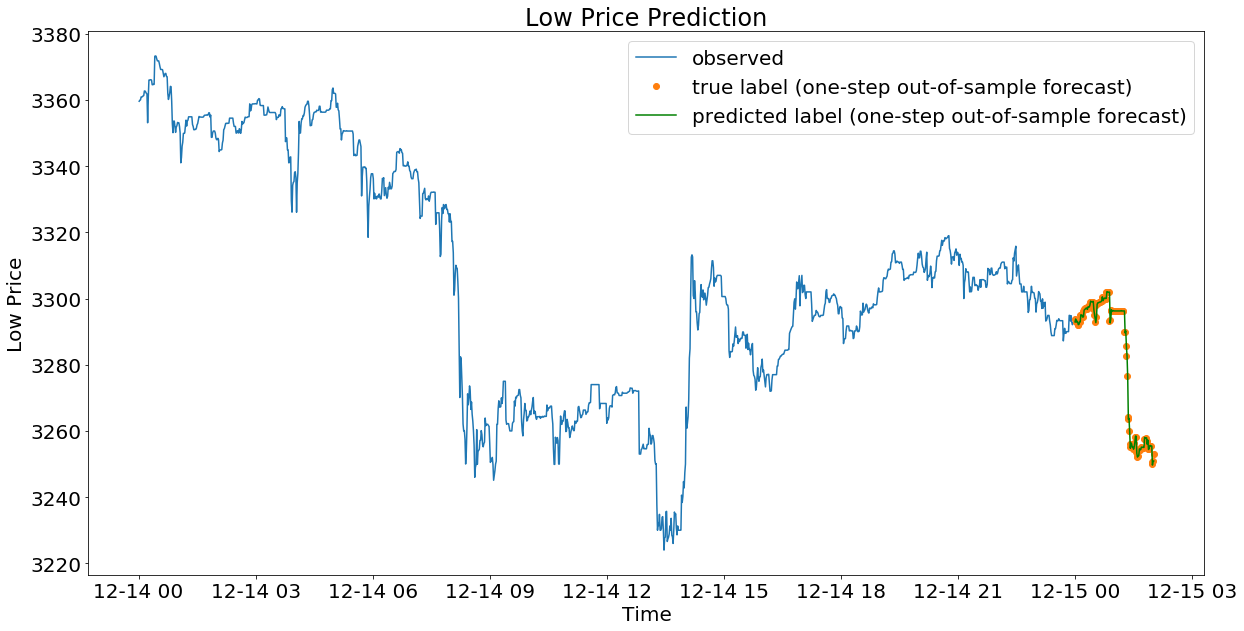

In [36]:
plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  

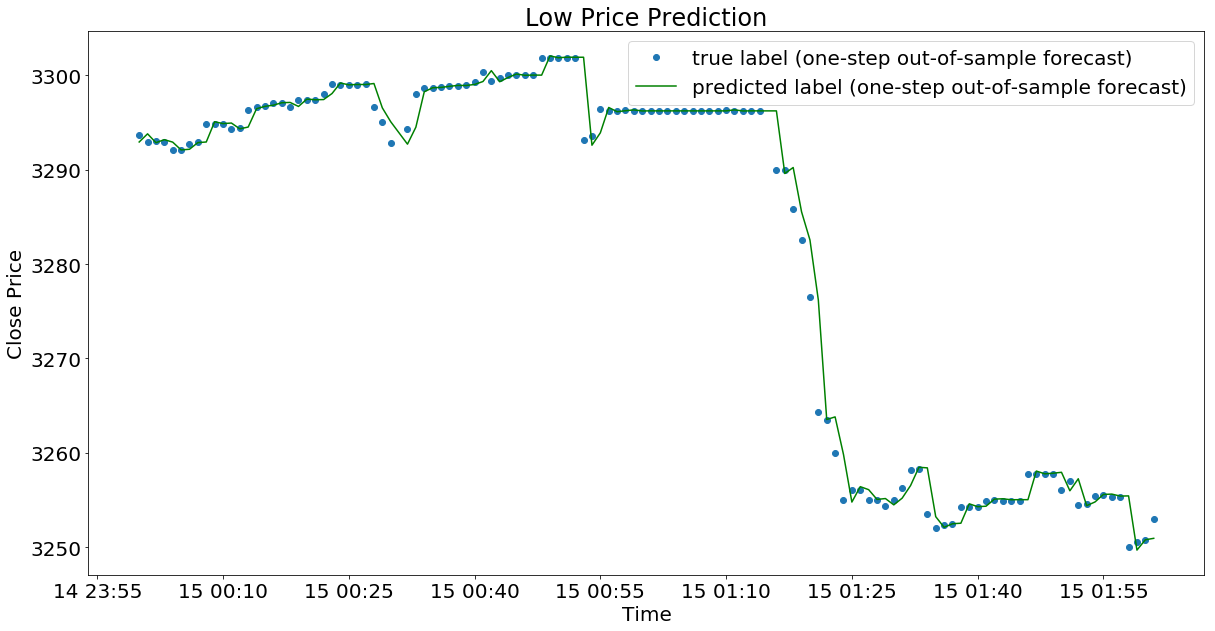

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set(title='Low Price Prediction', xlabel='Time', ylabel='Close Price')
#ax.plot(lowprice[:120], '-', label='observed')
ax.plot(test_lowprice[:120], 'o', label='true label (one-step out-of-sample forecast)')
ax.plot(predictions_series[:120], 'g', label='predicted label (one-step out-of-sample forecast)')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
plt.show()